In [10]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import shap

# Suppress warnings
warnings.filterwarnings("ignore")

In [11]:
# Read csv
df_user = pd.read_csv('df_user_aggregated.csv')

# Modelling

In [17]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38494 entries, 0 to 38493
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   new_id                           38494 non-null  object 
 1   SUCCESS_LEVEL_last               38494 non-null  object 
 2   GENDER_first                     38494 non-null  object 
 3   ADMIT_TERM_CODE_first            38494 non-null  object 
 4   APPL_STATUS_IN_CA_NAME_first     38494 non-null  object 
 5   CURRENT_STAY_STATUS_last         38494 non-null  object 
 6   PRIMARY_PROGRAM_CODE_first       38494 non-null  float64
 7   SessionId_count                  38494 non-null  int64  
 8   Timestamp_min                    38494 non-null  object 
 9   Timestamp_max                    38494 non-null  object 
 10  unique_active_days               38494 non-null  int64  
 11  log_deviation_from_program       38494 non-null  float64
 12  rolling_7d_avg_log

In [22]:
df_model = df_user.copy()

# Set index to new_id
df_model.set_index('new_id', inplace=True)

# Convert boolean columns to int
df_model['SUCCESS_STATUS'] = (df_model['SUCCESS_LEVEL_last'] == 'Successful').astype(int)
df_model.drop('SUCCESS_LEVEL_last',axis=1,inplace=True)

# Convert categorical columns to category type
df_model['PRIMARY_PROGRAM_CODE_first'] = df_model['PRIMARY_PROGRAM_CODE_first'].astype('category')
df_model['program_category'] = df_model['program_category'].astype('category')
df_model['PROGRAM_CREDENTIAL_mapped'] = df_model['PROGRAM_CREDENTIAL_mapped'].astype('category')

# Define features and target
features_to_exclude = [
    'ADMIT_TERM_CODE_first',
    'session_span_days', # Drop for potential leakage
    'AGE_GROUP_ordinal',
    'SUCCESS_STATUS',         # Target variable
    'Timestamp_min',          # Drop time-related columns that are not useful for modeling
    'Timestamp_max',
    'CURRENT_STAY_STATUS_last',  # Drop columns with categorical data that shouldn't be in features (leakage here)
    'APPL_STATUS_IN_CA_NAME_first',
    'ACADEMIC_PERFORMANCE_ordinal',
    'GENDER_first' #
    ,'PRIMARY_PROGRAM_CODE_first'           
]

# Feature matrix (X) and target vector (y)
X = df_model.drop(columns=features_to_exclude)
y = df_model['SUCCESS_STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [23]:

# --- 2. Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1],
}

# --- 3. Set up scorer ---
f1_scorer = make_scorer(f1_score, average='weighted')

# --- 4. Stratified K-Fold setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5. Define base XGBoost model ---
base_model = XGBClassifier(
    enable_categorical=True,
    eval_metric='logloss',
    booster='gbtree',
    random_state=42,
    n_jobs=-1
)

# --- 6. Grid search with cross-validation ---
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    error_score='raise'
)

# --- 7. Train the model ---
grid_search.fit(X_train, y_train)

# --- 8. Make predictions ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- 9. Report best results ---
print("\n Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n Best Weighted F1 Score (CV): {grid_search.best_score_:.4f}")

# --- 10. Evaluate on test set ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

# --- 11. Predict probabilities for later use ---
y_pred_proba = best_model.predict_proba(X_test)



 Best Hyperparameters:
   - colsample_bytree: 0.8
   - gamma: 0
   - learning_rate: 0.1
   - max_depth: 5
   - n_estimators: 200
   - subsample: 0.8

 Best Weighted F1 Score (CV): 0.7607

Classification Report:
              precision    recall  f1-score   support

           0     0.7528    0.7753    0.7639      4860
           1     0.7636    0.7403    0.7518      4764

    accuracy                         0.7580      9624
   macro avg     0.7582    0.7578    0.7578      9624
weighted avg     0.7582    0.7580    0.7579      9624


Confusion Matrix:
      0     1
0  3768  1092
1  1237  3527


In [24]:
X_train.head()

,SessionId_count,unique_active_days,log_deviation_from_program,rolling_7d_avg_logs,daily_log_std,weekly_log_std,longest_consecutive_active_days,rolling_avg_trend_slope,LOG_COUNT_first_week,LOG_STD_first_week,activity_delay_days,program_category,PROGRAM_CREDENTIAL_mapped
new_id,,,,,,,,,,,,,
01fd7f03efedb66b,646,93,42.196000,6.723400,4.431521,20.172353,45,1.263861e-08,14,2.065591,3.0,Community & Health Studies,Diploma
03a04d3f0913f1c1,399,86,-44.832487,4.695044,3.079010,8.899006,30,-2.112641e-07,25,1.722401,5.0,"Hospitality, Tourism & Culinary Arts",Diploma
05b61af0c5be08b0,262,80,-1.828326,3.324494,1.742797,6.056510,11,-1.432473e-07,25,2.228602,4.0,English & Liberal Studies,Certificate
3644ac37f667134e,298,66,-162.864553,4.463456,3.591625,13.111455,13,-2.425699e-07,23,2.994439,11.0,"Hospitality, Tourism & Culinary Arts",Diploma
482a2b63010b55dd,487,72,-42.884848,6.579134,4.501934,14.395075,68,2.042117e-07,23,2.926887,28.0,"Hospitality, Tourism & Culinary Arts",Diploma


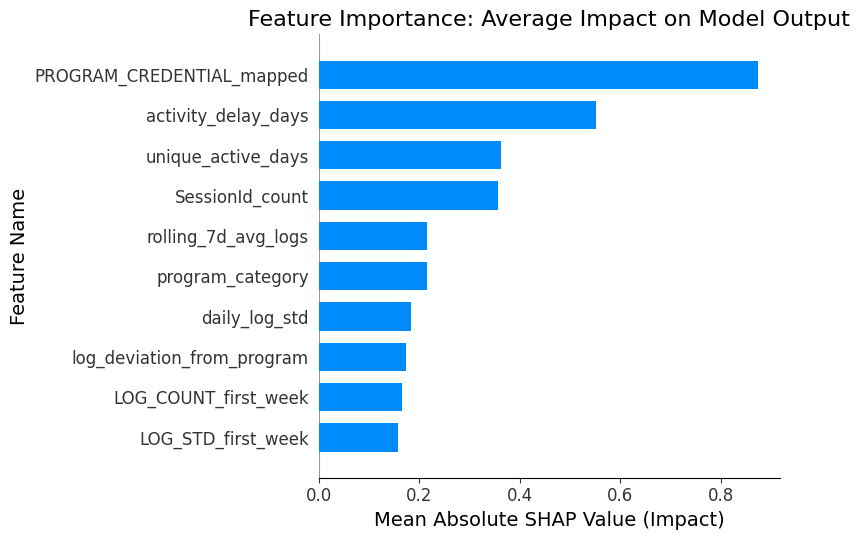

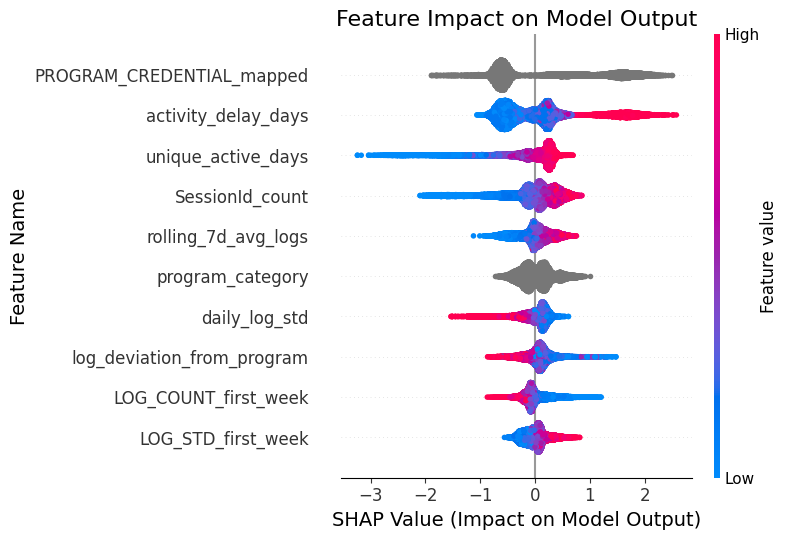

In [25]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# --- Summary Plot (Bar) ---
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type="bar", 
    max_display=10, 
    show=False  # Prevent auto-display to customize
)
plt.title("Feature Importance: Average Impact on Model Output", fontsize=16)
plt.xlabel("Mean Absolute SHAP Value (Impact)", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- Summary Plot (Scatter/Violin) ---
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
shap.summary_plot(
    shap_values, 
    X_train, 
    max_display=10, 
    show=False  # Prevent auto-display to customize
)
plt.title("Feature Impact on Model Output", fontsize=16)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

